In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import matplotlib.pyplot as plt
from PIL import Image


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
!git clone https://github.com/prajnasb/observations

fatal: destination path 'observations' already exists and is not an empty directory.


In [ ]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize((224,224)),
                                 transforms.ToTensor()]),
    'test': transforms.Compose([transforms.Resize((224,224)),
                                 transforms.ToTensor()]),
}

In [ ]:
data_dir = 'observations/experiements/dest_folder'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True) for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes
print(class_names)

['with_mask', 'without_mask']


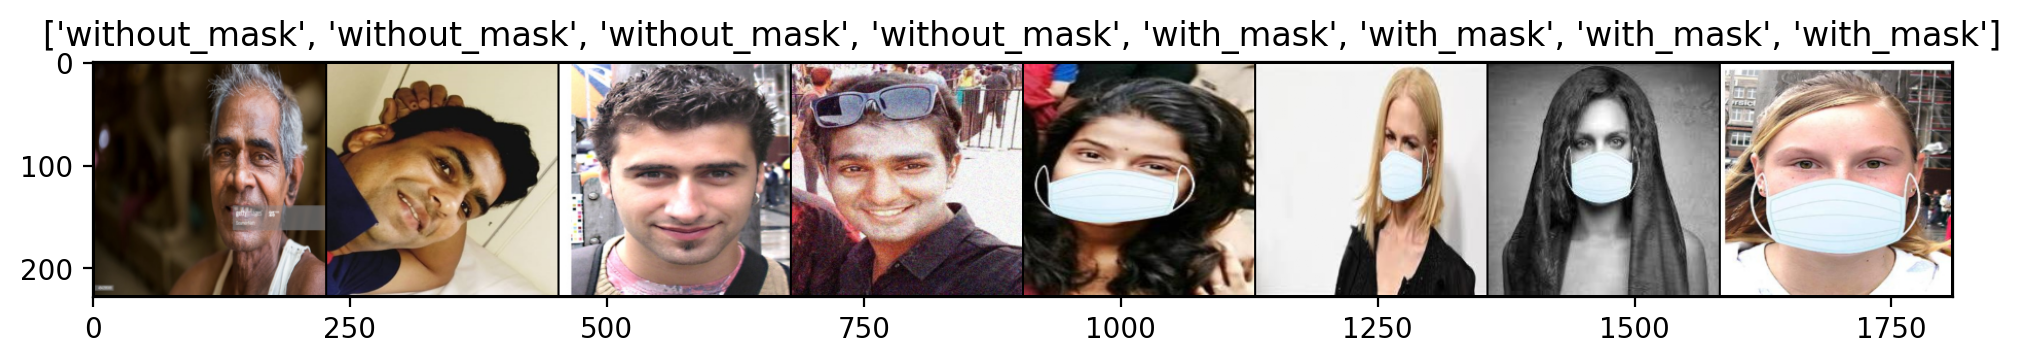

In [ ]:
plt.figure(figsize=(12,8))

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

# **Treinamento**

In [ ]:
model = models.efficientnet_b0(pretrained=True)
model = model.to(device)

for param in model.parameters():
  param.requires_grad = False


num_ftrs = model.classifier[-1].in_features

model.classifier[-1] = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 101MB/s]


In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.2871 Acc: 0.9034
test Loss: 0.1147 Acc: 0.9794

Epoch 1/14
----------
train Loss: 0.1592 Acc: 0.9483
test Loss: 0.0791 Acc: 0.9794

Epoch 2/14
----------
train Loss: 0.1348 Acc: 0.9468
test Loss: 0.0722 Acc: 0.9742

Epoch 3/14
----------
train Loss: 0.0991 Acc: 0.9681
test Loss: 0.0547 Acc: 0.9845

Epoch 4/14
----------
train Loss: 0.1042 Acc: 0.9650
test Loss: 0.0679 Acc: 0.9742

Epoch 5/14
----------
train Loss: 0.1088 Acc: 0.9536
test Loss: 0.0401 Acc: 0.9948

Epoch 6/14
----------
train Loss: 0.1006 Acc: 0.9643
test Loss: 0.0513 Acc: 0.9845

Epoch 7/14
----------
train Loss: 0.0819 Acc: 0.9665
test Loss: 0.0518 Acc: 0.9845

Epoch 8/14
----------
train Loss: 0.0962 Acc: 0.9673
test Loss: 0.0407 Acc: 0.9948

Epoch 9/14
----------
train Loss: 0.0939 Acc: 0.9650
test Loss: 0.0540 Acc: 0.9794

Epoch 10/14
----------
train Loss: 0.1167 Acc: 0.9597
test Loss: 0.0576 Acc: 0.9845

Epoch 11/14
----------
train Loss: 0.0829 Acc: 0.9688
test Loss: 0.0472 Acc

In [ ]:
torch.save(model,'/content/sample_data/face_mask_model_efficientnet.pth')

In [ ]:
caminho_modelo = '/content/sample_data/face_mask_model_efficientnet.pth'

modelo = torch.load(caminho_modelo)

modelo.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

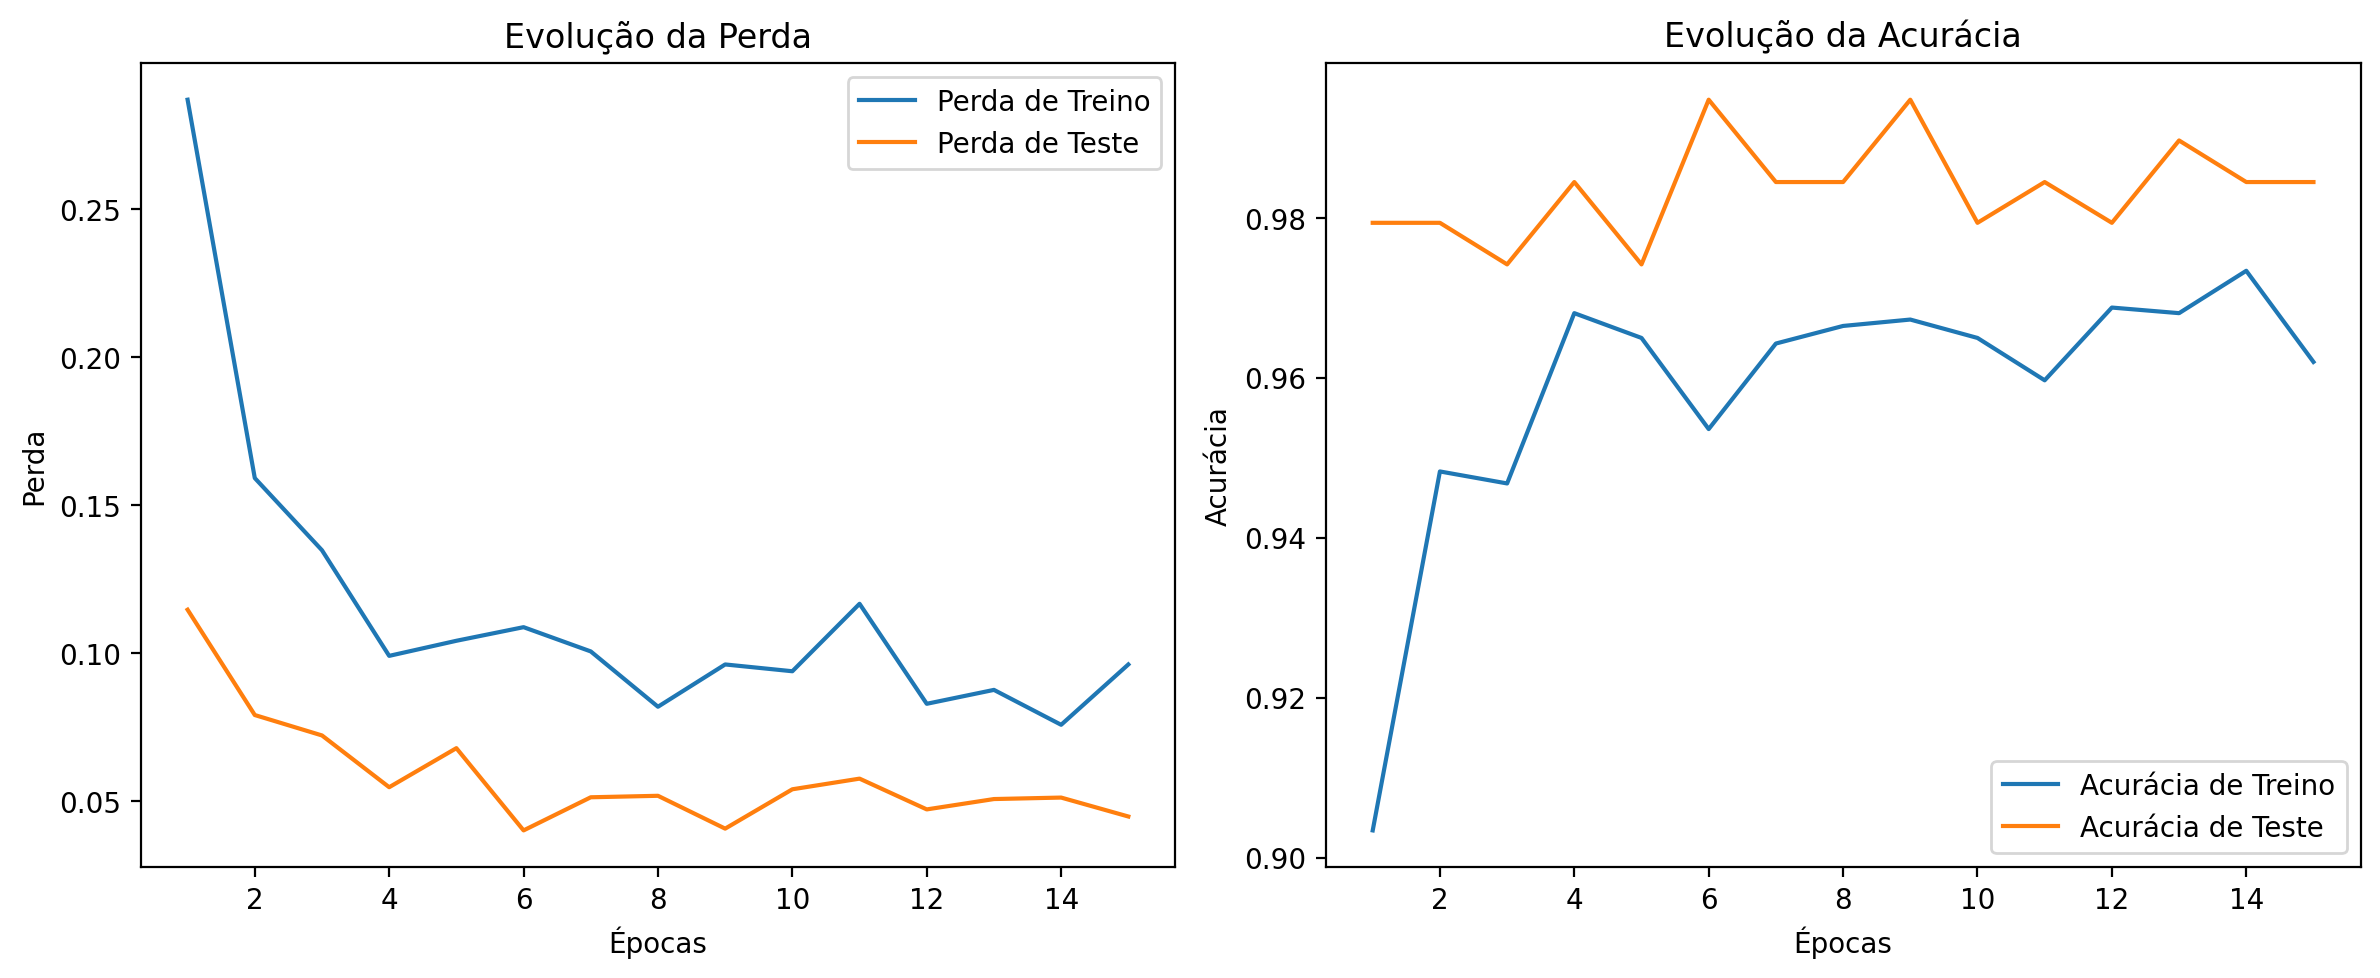

In [ ]:
import matplotlib.pyplot as plt

# Dados das épocas
epochs = range(1, 16)  # 15 épocas
train_loss = [0.2871, 0.1592, 0.1348, 0.0991, 0.1042, 0.1088, 0.1006, 0.0819, 0.0962, 0.0939, 0.1167, 0.0829, 0.0876, 0.0758, 0.0962]
train_acc = [0.9034, 0.9483, 0.9468, 0.9681, 0.9650, 0.9536, 0.9643, 0.9665, 0.9673, 0.9650, 0.9597, 0.9688, 0.9681, 0.9734, 0.9620]
test_loss = [0.1147, 0.0791, 0.0722, 0.0547, 0.0679, 0.0401, 0.0513, 0.0518, 0.0407, 0.0540, 0.0576, 0.0472, 0.0507, 0.0512, 0.0448]
test_acc = [0.9794, 0.9794, 0.9742, 0.9845, 0.9742, 0.9948, 0.9845, 0.9845, 0.9948, 0.9794, 0.9845, 0.9794, 0.9897, 0.9845, 0.9845]


# Gráfico de perda
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Perda de Treino')
plt.plot(epochs, test_loss, label='Perda de Teste')
plt.title('Evolução da Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Gráfico de acurácia
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Acurácia de Treino')
plt.plot(epochs, test_acc, label='Acurácia de Teste')
plt.title('Evolução da Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()
plt.show()


In [ ]:
from prettytable import PrettyTable

# Dados das épocas
epochs = range(1, 15)
train_loss = [0.2871, 0.1592, 0.1348, 0.0991, 0.1042, 0.1088, 0.1006, 0.0819, 0.0962, 0.0939, 0.1167, 0.0829, 0.0876, 0.0758, 0.0962]
train_acc = [0.9034, 0.9483, 0.9468, 0.9681, 0.9650, 0.9536, 0.9643, 0.9665, 0.9673, 0.9650, 0.9597, 0.9688, 0.9681, 0.9734, 0.9620]
test_loss = [0.1147, 0.0791, 0.0722, 0.0547, 0.0679, 0.0401, 0.0513, 0.0518, 0.0407, 0.0540, 0.0576, 0.0472, 0.0507, 0.0512, 0.0448]
test_acc = [0.9794, 0.9794, 0.9742, 0.9845, 0.9742, 0.9948, 0.9845, 0.9845, 0.9948, 0.9794, 0.9845, 0.9794, 0.9897, 0.9845, 0.9845]

# Criar a tabela
table = PrettyTable()
table.field_names = ["Época", "Perda de Treino", "Acurácia de Treino", "Perda de Teste", "Acurácia de Teste"]

for i in range(14):
    table.add_row([epochs[i], train_loss[i], train_acc[i], test_loss[i], test_acc[i]])

# Exibir a tabela
print(table)


+-------+-----------------+--------------------+----------------+-------------------+
| Época | Perda de Treino | Acurácia de Treino | Perda de Teste | Acurácia de Teste |
+-------+-----------------+--------------------+----------------+-------------------+
|   1   |      0.2871     |       0.9034       |     0.1147     |       0.9794      |
|   2   |      0.1592     |       0.9483       |     0.0791     |       0.9794      |
|   3   |      0.1348     |       0.9468       |     0.0722     |       0.9742      |
|   4   |      0.0991     |       0.9681       |     0.0547     |       0.9845      |
|   5   |      0.1042     |       0.965        |     0.0679     |       0.9742      |
|   6   |      0.1088     |       0.9536       |     0.0401     |       0.9948      |
|   7   |      0.1006     |       0.9643       |     0.0513     |       0.9845      |
|   8   |      0.0819     |       0.9665       |     0.0518     |       0.9845      |
|   9   |      0.0962     |       0.9673       |     0

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Função para carregar e pré-processar a imagem
def load_image(image_path):
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)
    return image


model_path = '/content/sample_data/face_mask_model_efficientnet.pth'
model = torch.load(model_path)
model.eval()

image_paths = [
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img1.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img2.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img3.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img4.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img5.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img6.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img7.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img8.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img9.jpeg'
]

# Mapeamento das classes
class_names = ['with_mask', 'without_mask']


predictions = []

# Realizar a predição para cada imagem
for image_path in image_paths:
    input_image = load_image(image_path)

    with torch.no_grad():
        outputs = model(input_image)
        _, preds = torch.max(outputs, 1)
        predicted_class = class_names[preds.item()]
        predictions.append(predicted_class)

# Exibir as imagens e suas predições
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths):
    image = Image.open(image_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f'Predição: {predictions[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
